# Data Pre-Processing

#### Import Packages and CSV

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option("display.max_columns", None)
# Create Dataframe
df = pd.read_csv(r"/home/vinod/projects_1/Heart_Stroke_ANN/notebooks/data/healthcare-dataset-stroke-data.csv")
# Print shape of dataset
print(df.shape)

(5110, 12)


In [2]:
# First 5 rows of the dataset
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Data Cleaning

#### Check Null Values

In [3]:
##these are the features with nan value
features_with_na=[features for features in df.columns if df[features].isnull().sum()>=1]
for feature in features_with_na:
    print(feature,np.round(df[feature].isnull().mean()*100,5), '% missing values')

bmi 3.93346 % missing values


### 3.2 Other Data Cleaning steps

**Handling Duplicates**

In [4]:
# Checking for duplicates
df.duplicated().sum()

0

**Remove ID from the dataset as it cannot used in Model Training**

**As a Report form the EDA we can drop `gender` and `Resident_type` as well**

In [5]:
df.drop(['id', 'gender', 'Residence_type'], inplace=True, axis=1)

# Feature Engineering

### Type of Features

In [6]:
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']
print('Num of Numerical Features :', len(numeric_features))
numeric_features

Num of Numerical Features : 6


['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']

In [7]:
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']
print('Num of Categorical Features :', len(categorical_features))
categorical_features

Num of Categorical Features : 3


['ever_married', 'work_type', 'smoking_status']

**Discrete Features**

In [8]:
discrete_features=[feature for feature in numeric_features if (len(df[feature].unique())<=25)]
print('Num of Discrete Features :',len(discrete_features))
discrete_features

Num of Discrete Features : 3


['hypertension', 'heart_disease', 'stroke']

**Continuous features**

In [9]:
continuous_features=[feature for feature in numeric_features if len(df[feature].unique()) > 25]
print('Num of Continuous Features :',len(continuous_features))
continuous_features

Num of Continuous Features : 3


['age', 'avg_glucose_level', 'bmi']

**Imputing Null Values to Check VIF(Multi-Collinearity)**

In [10]:
# Create copy of dataframe to check variance inflation factor
df1 = df.copy()
for i in continuous_features:
    df1[i].fillna(df1[i].median(), inplace=True)

### Multicollinearity Check
#### Variance Inflation Factor (VIF)

* Multicollinearity occurs when there are two or more independent variables in a multiple regression model, which have a high correlation among themselves. When some features are highly correlated.
* Multicollinearity can be detected using various techniques, one such technique being the Variance Inflation Factor(VIF).

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def compute_vif(considered_features, df):
    
    X = df[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

In [12]:
compute_vif(continuous_features, df1)

,Variable,VIF
0,age,1.162810
1,avg_glucose_level,1.070325
2,bmi,1.128268


 ” VIF determines the strength of the correlation between the independent variables. It is predicted by taking a variable and regressing it against every other variable “ 

VIF above 5 is indicator of Multicollinearity  

**- This Dataset Doesnt have any Multicollinearity**

### Check Outlier and Capping it

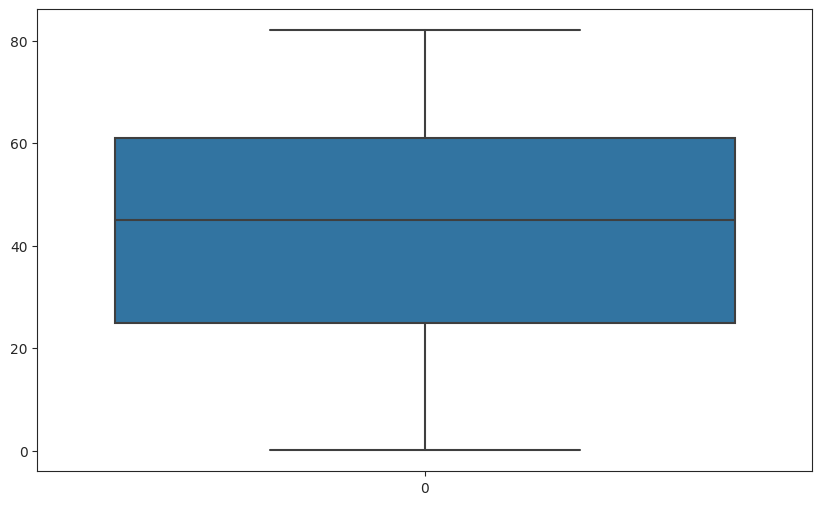

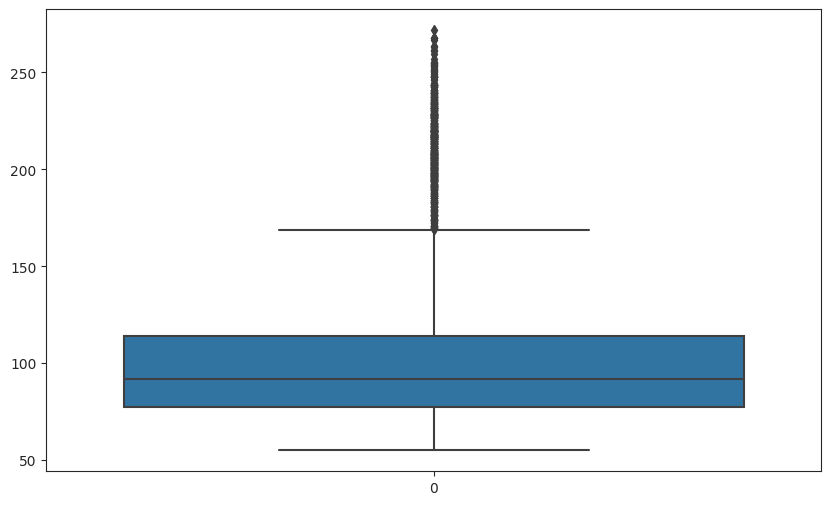

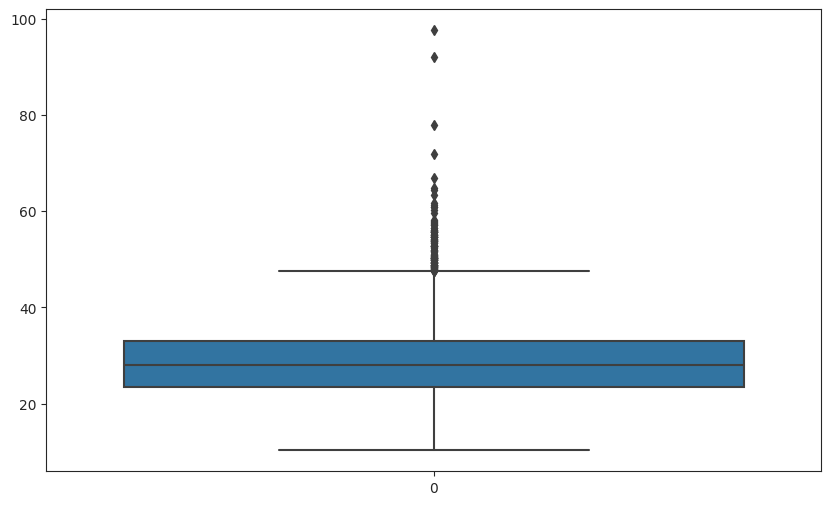

In [13]:
for i in continuous_features:
        plt.figure(figsize=(10,6))
        sns.set_style('ticks')
        ax = sns.boxplot(df[i])

**Standard deviation method For Outlier Handling?**

- Outlier removal using standard deviation procedure.
- Usually z-score =3 is considered as a cut-off value to set the limit. Therefore, any z-score greater than +3 or less than -3 is considered as outlier which is pretty much similar to standard deviation method.
- Here we can remove outliers after 3rd standard deviation or z-score +3 and -3. used to remove only extreme outlier points

In [14]:
def outlier_removal(column, df):
    upper_limit = df[column].mean() + 3*df[column].std()
    lower_limit = df[column].mean() - 3*df[column].std()
    df = df[(df[column] < upper_limit) & (df[column] > lower_limit)]
    return df

In [15]:
df.shape

(5110, 9)

In [16]:
outlier_feature = ['bmi']

In [17]:
for i in range(len(outlier_feature)):
    df = outlier_removal(outlier_feature[i], df)

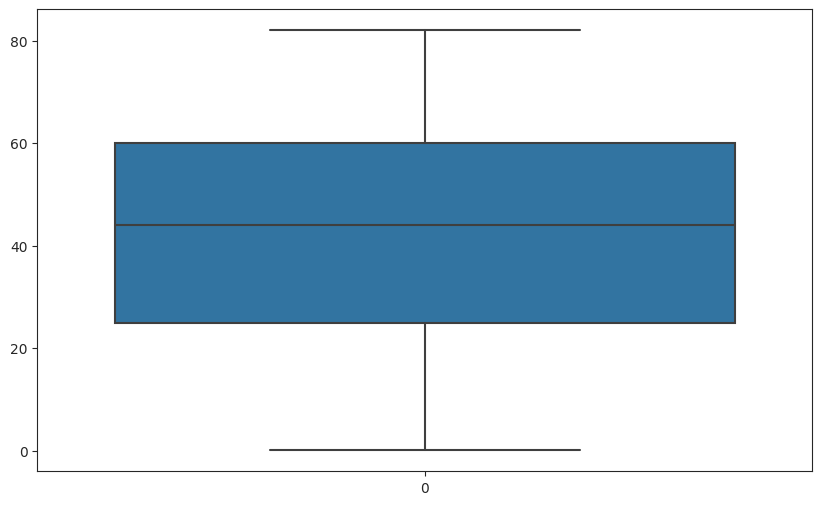

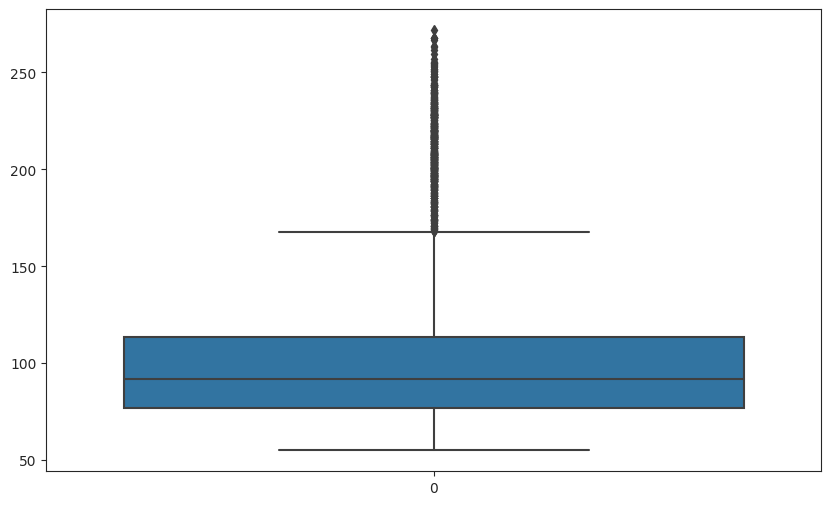

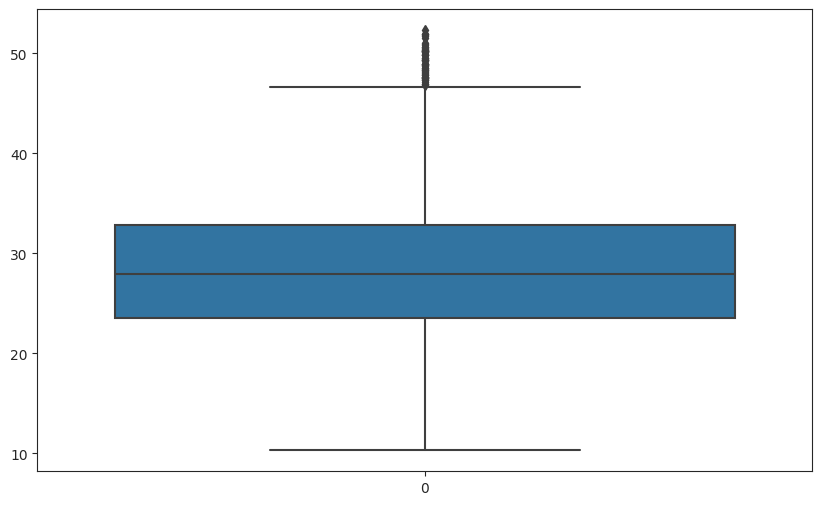

In [18]:
for i in continuous_features:
        plt.figure(figsize=(10,6))
        sns.set_style('ticks')
        ax = sns.boxplot(df[i])

In [19]:
df.shape

(4851, 9)

## Feature Transformation

In [20]:
df[continuous_features].skew(axis=0)

age                 -0.115593
avg_glucose_level    1.626970
bmi                  0.466922
dtype: float64

* **If Skewness is above 2 then the feature is Highly skewed**
* **If Skewness is above 1.5 then the feature is Moderately skewed**

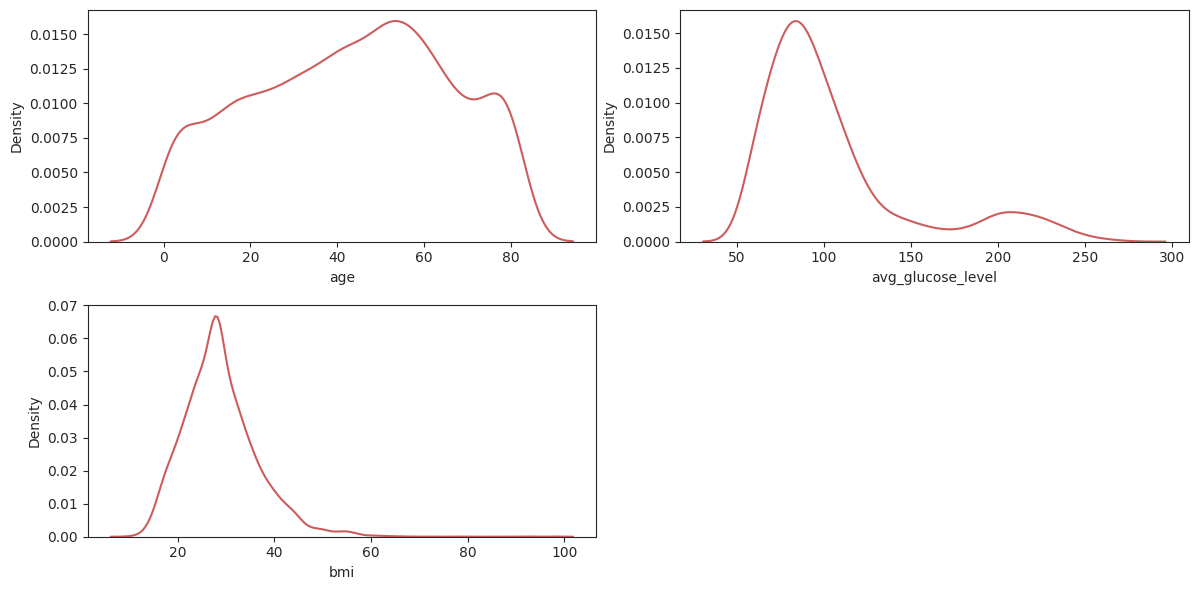

In [21]:
# distribution of data before scaling
plt.figure(figsize=(12, 6))
for i, col in enumerate(continuous_features):
    plt.subplot(2, 2, i+1)
    sns.kdeplot(x=df1[col], color='indianred')
    plt.xlabel(col)
    plt.tight_layout()

- **Here `avg_glucose_level` is slightly skewed**
- **`age` column have kutosis and it is platykurtic**
- **`bmi` is normally distributed with very little data on the tails**

In [22]:
df.head(5)

,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status,stroke
0,67.0,0,1,Yes,Private,228.69,36.6,formerly smoked,1
2,80.0,0,1,Yes,Private,105.92,32.5,never smoked,1
3,49.0,0,0,Yes,Private,171.23,34.4,smokes,1
4,79.0,1,0,Yes,Self-employed,174.12,24.0,never smoked,1
5,81.0,0,0,Yes,Private,186.21,29.0,formerly smoked,1


### Split X and Y

In [23]:
from sklearn.model_selection import train_test_split
X = df.drop(['stroke'], axis=1)
y = df['stroke']

* **Split Dataframe to X and y**
* **Here we set a variable X i.e, independent columns, and a variable y i.e, dependent column as the `stroke` column.**


In [24]:
for feature in categorical_features:
    print(feature,':', X[feature].nunique())

ever_married : 2
work_type : 5
smoking_status : 4


## Feature Encoding and Scaling

 **One Hot Encoding for Columns which had lesser unique values and not ordinal**
* One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.

In [25]:
for i in continuous_features:
    print(f'{i}: mean = {df[i].mean():.2f}, median = {df[i].median():.2f}')

age: mean = 42.83, median = 44.00
avg_glucose_level: mean = 105.10, median = 91.68
bmi: mean = 28.54, median = 27.90


There are no missing values in `age` and `avg_glucose_level` and only `bmi` column should be handled. Based on the above result we can inpute the column with either mean or median. We can go with median imputation since it is robust than mean imputer.

* **Mean imputer:** Since we handeled outlier for the continuous features the mean and median of the features are nearly same. When there are no outliers mean performs an a better imputer.
* **Standardscaler:** As the features distribution are nearly normal we use standard scaler.
* **Power Transformer:** Since avg_glucose_level are skewed we use Power Transformer on them

In [26]:
# Create Column Transformer with 3 types of transformers
categorical_features = X.select_dtypes(include="object").columns
num_feature = numeric_features.copy()
num_feature.remove('stroke')
transform_features=['avg_glucose_level']


from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('one_hot_encoder', OneHotEncoder()),
    ('scaler', StandardScaler(with_mean=False))
]
)

transform_pipe = Pipeline(steps=[
    ('transformer', PowerTransformer(standardize=True))
])

preprocessor = ColumnTransformer(
    [
        ("numeric_Pipeline",numeric_pipeline,num_feature),
        ("Categorical_Pipeline",categorical_pipeline, categorical_features),
        ("Power_Transformation", transform_pipe, transform_features)
]
)

In [27]:
X= preprocessor.fit_transform(X)

## Handling Imbalanced Dataset

* Handling Imbalanced Target Variable.
* Synthetic Minority Oversampling Technique or SMOTE is another technique to oversample the minority class. Simply adding duplicate records of minority class often don’t add any new information to the model.

* SMOTE is one of the famous oversampling techniques and is very effective in handling class imbalance. The idea is to combine SMOTE with some undersampling techniques (ENN, Tomek) to increase the effectiveness of handling the imbalanced class.

 **SMOTE+ENN** is one of such a hybrid technique that aims to clean overlapping data points for each of the classes distributed in sample space.
 
This method combines the SMOTE ability to generate synthetic data for minority class and uses ENN to remove overlapping observation of both the classes
 
 - **To add new data of minority class**
 1. Choose random data from the minority class.
 2. Calculate the distance between the random data and its k nearest neighbors.
 3. Multiply the difference with a random number between 0 and 1, then add the result to the minority class as a synthetic sample.
 4. Repeat step number 2–3 until the desired proportion of minority class is met.
 
 - **To remove the data points of both classes**
 1. Determine K, as the number of nearest neighbors. If not determined, then K=3.
 2. Find the K-nearest neighbor of the observation among the other observations in the dataset, then return the majority class from the K-nearest neighbor.
 3. If the class of the observation and the majority class from the observation’s K-nearest neighbor is different, then the observation and its K-nearest neighbor are deleted from the dataset.
 4. Repeat step 2 and 3 until the desired proportion of each class is fulfilled.
 
 - This is method instead of adding duplicate data it synthesises the new data based on the already avalialble classes. Hence we choose this as our imputer method for this problem.

In [28]:
from imblearn.combine import SMOTETomek, SMOTEENN

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTEENN(random_state=42,sampling_strategy='minority' )
# Fit the model to generate the data.
X, y = smt.fit_resample(X, y)

In [29]:
X[0]

array([-1.75942083, -0.31385575, -0.2291418 , -0.22600995, -1.47463119,
        2.09767055,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  2.89655563,  2.17637423,  0.        ,  0.        ,
        0.        ,  0.094787  ])

## Model Selection
* **Here should understand the Various Classification models with default values from these models we can choose top 4 with Highest Accuracy score and proceed with HyperParameter Tuning**

## Train Test Split

**Import Required packages for model training**

In [30]:
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import keras_tuner as kt

2023-07-09 16:30:40.284482: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-09 16:30:40.286366: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-09 16:30:40.323294: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-09 16:30:40.323915: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-09 16:30:41.031735: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [31]:
# separate dataset into validation, train and test
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

In [32]:
model = Sequential()

model.add(Dense(17, activation='relu', input_dim=17))
model.add(Dense(10, activation='relu'))
model.add(Dense(5,activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 17)                306       
                                                                 
 dense_1 (Dense)             (None, 10)                180       
                                                                 
 dense_2 (Dense)             (None, 5)                 55        
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 547
Trainable params: 547
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.compile(loss="binary_crossentropy", optimizer='Adam', metrics=['accuracy'])

In [35]:
result = model.fit(X_train, y_train, epochs=100, validation_split=0.3)

Epoch 1/100
139/139 [==============================] - 1s 3ms/step - loss: 0.6060 - accuracy: 0.6677 - val_loss: 0.5212 - val_accuracy: 0.7698
Epoch 2/100
139/139 [==============================] - 0s 2ms/step - loss: 0.4825 - accuracy: 0.7854 - val_loss: 0.4298 - val_accuracy: 0.8405
Epoch 3/100
139/139 [==============================] - 0s 2ms/step - loss: 0.4074 - accuracy: 0.8450 - val_loss: 0.3734 - val_accuracy: 0.8664
Epoch 4/100
139/139 [==============================] - 0s 2ms/step - loss: 0.3600 - accuracy: 0.8619 - val_loss: 0.3445 - val_accuracy: 0.8796
Epoch 5/100
139/139 [==============================] - 0s 2ms/step - loss: 0.3306 - accuracy: 0.8787 - val_loss: 0.3257 - val_accuracy: 0.8823
Epoch 6/100
139/139 [==============================] - 0s 2ms/step - loss: 0.3126 - accuracy: 0.8864 - val_loss: 0.3129 - val_accuracy: 0.8875
Epoch 7/100
139/139 [==============================] - 0s 2ms/step - loss: 0.3001 - accuracy: 0.8875 - val_loss: 0.3038 - val_accuracy: 0.8923

Epoch 58/100
139/139 [==============================] - 0s 2ms/step - loss: 0.1348 - accuracy: 0.9547 - val_loss: 0.1710 - val_accuracy: 0.9446
Epoch 59/100
139/139 [==============================] - 0s 2ms/step - loss: 0.1340 - accuracy: 0.9534 - val_loss: 0.1695 - val_accuracy: 0.9456
Epoch 60/100
139/139 [==============================] - 0s 2ms/step - loss: 0.1407 - accuracy: 0.9525 - val_loss: 0.1693 - val_accuracy: 0.9467
Epoch 61/100
139/139 [==============================] - 0s 2ms/step - loss: 0.1330 - accuracy: 0.9550 - val_loss: 0.1686 - val_accuracy: 0.9440
Epoch 62/100
139/139 [==============================] - 0s 2ms/step - loss: 0.1314 - accuracy: 0.9556 - val_loss: 0.1687 - val_accuracy: 0.9472
Epoch 63/100
139/139 [==============================] - 0s 2ms/step - loss: 0.1290 - accuracy: 0.9563 - val_loss: 0.1656 - val_accuracy: 0.9488
Epoch 64/100
139/139 [==============================] - 0s 2ms/step - loss: 0.1298 - accuracy: 0.9572 - val_loss: 0.1655 - val_accuracy:

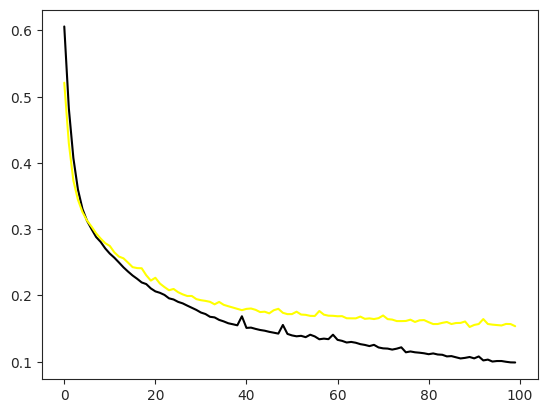

In [36]:
plt.plot(result.history['loss'], color="black")
plt.plot(result.history['val_loss'], color='yellow')

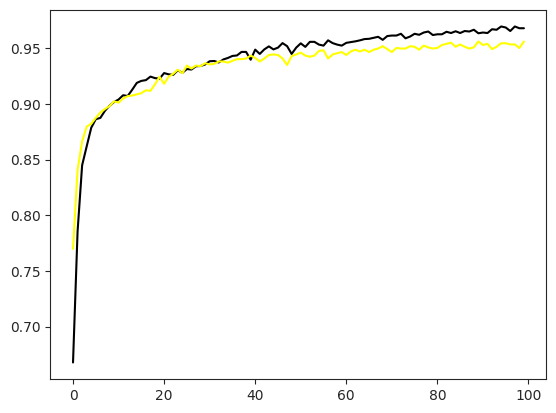

In [37]:
plt.plot(result.history['accuracy'], color='black' )
plt.plot(result.history['val_accuracy'], color='yellow')

# Hyper-parameter tuning

In [38]:
def build_model(hp):
    model = keras.Sequential()
    model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=512, step=32),
                                 activation=hp.Choice('activation_1', values=['relu', 'tanh']),
                                 input_shape=(17,)))

    # Tune the number of layers and nodes
    for i in range(hp.Int('num_of_layers', min_value=1, max_value=5)):
        model.add(Dense(units=hp.Int(f'units_{i+2}', min_value=32, max_value=512, step=32),
                                     activation=hp.Choice(f'activation_{i+2}', values=['relu', 'tanh'])))

    model.add(Dense(1, activation='sigmoid'))  # Output layer

    # Tune the optimizer choice and learning rate
    optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'adadelta'])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Perform hyperparameter tuning
tuner = kt.Hyperband(build_model, 
                     objective='val_accuracy', 
                     max_epochs=10, 
                     factor=3)

tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

# Get the best model and its hyperparameters
best_model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]


INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json
INFO:tensorflow:Oracle triggered exit


### these are the best parameters and summary of the model

In [39]:
print("Best Model:")
best_model.summary()

print("\nBest Hyperparameters:")
for key, value in best_hyperparameters.values.items():
    print(f"{key}: {value}")

Best Model:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2304      
                                                                 
 dense_1 (Dense)             (None, 192)               24768     
                                                                 
 dense_2 (Dense)             (None, 288)               55584     
                                                                 
 dense_3 (Dense)             (None, 128)               36992     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 384)               24960     
                                                                 
 dense_6 (Dense)             (None, 1)      

### Get the values/ parameters from the result of hyperparameter tuning and build a Dense model and train again

### And I'm using Early stopping because with the best parameters, model may result in overfit or underfit

In [40]:
# Create a new sequential model with the best hyperparameters
final_model = keras.Sequential()

# Add layers based on the best hyperparameters
final_model.add(keras.layers.Dense(units=128, activation='tanh', input_shape=(17,)))  # input_shape depends on your input data shape

num_of_layers = best_hyperparameters.get('num_of_layers')

for i in range(2, 2 + num_of_layers):
    units_key = f'units_{i}'
    activation_key = f'activation_{i}'
    units = best_hyperparameters.get(units_key)
    activation = best_hyperparameters.get(activation_key)

    final_model.add(keras.layers.Dense(units=units, activation=activation))

final_model.add(keras.layers.Dense(1, activation='sigmoid'))  # Output layer

# Compile the model
optimizer = best_hyperparameters.get('optimizer')
final_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model with early stopping
result1 = final_model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100
198/198 [==============================] - 2s 5ms/step - loss: 0.3182 - accuracy: 0.8641 - val_loss: 0.2767 - val_accuracy: 0.8859
Epoch 2/100
198/198 [==============================] - 1s 3ms/step - loss: 0.2322 - accuracy: 0.9089 - val_loss: 0.2306 - val_accuracy: 0.8999
Epoch 3/100
198/198 [==============================] - 1s 4ms/step - loss: 0.1872 - accuracy: 0.9292 - val_loss: 0.1990 - val_accuracy: 0.9113
Epoch 4/100
198/198 [==============================] - 1s 4ms/step - loss: 0.1570 - accuracy: 0.9417 - val_loss: 0.1407 - val_accuracy: 0.9442
Epoch 5/100
198/198 [==============================] - 1s 4ms/step - loss: 0.1362 - accuracy: 0.9488 - val_loss: 0.1357 - val_accuracy: 0.9480
Epoch 6/100
198/198 [==============================] - 1s 3ms/step - loss: 0.1153 - accuracy: 0.9577 - val_loss: 0.1588 - val_accuracy: 0.9468
Epoch 7/100
198/198 [==============================] - 1s 4ms/step - loss: 0.1097 - accuracy: 0.9604 - val_loss: 0.1474 - val_accuracy: 0.9455

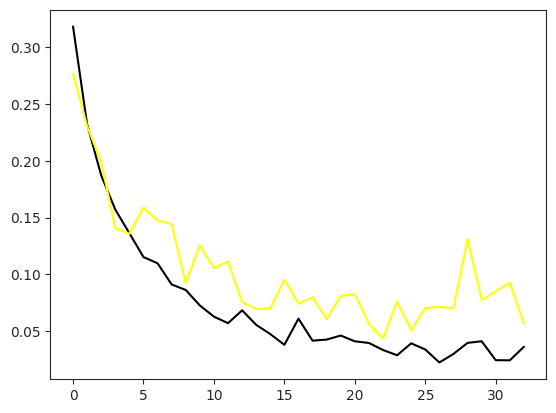

In [41]:
plt.plot(result1.history['loss'], color='black')
plt.plot(result1.history['val_loss'], color='yellow')

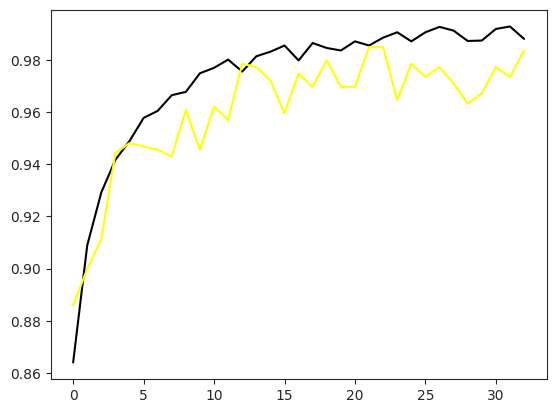

In [42]:
plt.plot(result1.history['accuracy'], color='black')
plt.plot(result1.history['val_accuracy'], color='yellow')

In [43]:
# Predict on test data
y_pred = final_model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")
score = accuracy_score(y_test, y_pred_classes)
cr = classification_report(y_test, y_pred_classes)

print("FINAL MODEL 'ANN'")
print("Accuracy Score value: {:.4f}".format(score))
print(cr)

25/25 [==============================] - 0s 2ms/step
FINAL MODEL 'ANN'
Accuracy Score value: 0.9747
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       377
           1       0.97      0.99      0.98       413

    accuracy                           0.97       790
   macro avg       0.98      0.97      0.97       790
weighted avg       0.97      0.97      0.97       790



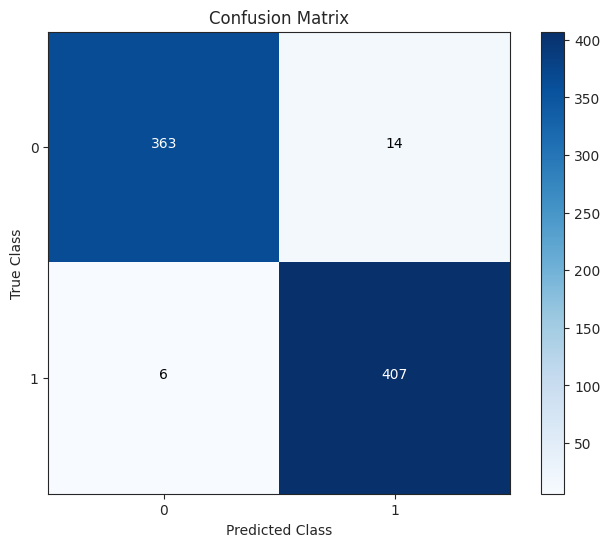

In [44]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Define class labels
class_labels = np.unique(y)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

# Add labels to each cell
thresh = cm.max() / 2.0
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.show()

## So the best model of accuracy is : 97.47%